In [6]:
# Ref: https://github.com/nikhilbarhate99/PPO-PyTorch

############################### Import libraries ###############################


import os
import glob
import time
from datetime import datetime
from collections import namedtuple, deque
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

import numpy as np

import gym



################################## set device ##################################

print("============================================================================================")


# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")
    
print("============================================================================================")




################################## PPO Policy ##################################


class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []
    

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)

        # actor
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Tanh()
                        )
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Softmax(dim=-1)
                        )

        
        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )
        
    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def forward(self):
        raise NotImplementedError
    

    def act(self, state):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)

        return action.detach(), action_logprob.detach(), state_val.detach()
    

    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)
            
            # for single action continuous environments
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)

        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        
        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()


    def set_action_std(self, new_action_std):
        
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")

        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")

        print("--------------------------------------------------------------------------------------------")


    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.detach().cpu().numpy().flatten()

        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)
            
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.item()


    def update(self):

        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(device)

        # calculate advantages
        advantages = rewards.detach() - old_state_values.detach()
        

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()
    
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
   

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        
        
       



Device set to : A100-PCIE-80GB


In [7]:


Action = namedtuple('Action', 'name index delta_i delta_j')
    
up = Action('up', 0, -1, 0)    
down = Action('down', 1, 1, 0)    
left = Action('left', 2, 0, -1)    
right = Action('right', 3, 0, 1)    

index_to_actions = {}
for action in [up, down, left, right]:
    index_to_actions[action.index] = action

str_to_actions = {}
for action in [up, down, left, right]:
    str_to_actions[action.name] = action


class Town:
    def __init__(self, rows, cols, height=600, width=600, background_color=(0,100,0)) -> None:



        
        self.height = height
        self.width = width
        self.rows = rows
        self.cols = cols
        self.block_size = height//self.rows
        self.background_color = background_color
        self.black_color = (0,0,0)
        self.red = (200,0,0)

        #this array will be the representation of our environment:
        self.town = np.zeros((rows, cols), dtype = np.int8)

        self.town[0, :] = 7
        self.town[-1, :] = 7
        self.town[:, 0] = 7
        self.town[:, -1] = 7
        

        #defining the objects in the environment:
                # display help
        #X : Enemy , P: Prison, A: Agent (Prince), R: Restaurant, B: Bar, S: Safe House
        self.dict_map_display={ 0:'.',
                                1:'A',
                                2:'P',
                                3:'R',
                                4:'B',
                                5:'S',
                                6:'X',
                                7:'W'}

        #defining a random coordinate for the starting position of our prince(A)
        # self.prince_start = self.get_empty_cells(1)
        # self.town[self.prince_start[0], self.prince_start[1]] = 1
        self.prince_pos = None

        #defining a random coordinate for the prison where princess is captured
        self.princess_start = self.get_empty_cells(1)
        self.town[self.princess_start[0], self.princess_start[1]] = 2

         # defining rows//5 random coordinates for the Restaurant
        self.restaurant_pos = self.get_empty_cells( int(self.rows//10) )
        self.town[self.restaurant_pos[0], self.restaurant_pos[1]] = 3

        #defining rows//5 random coordinates for the bars
        self.pub_pos = self.get_empty_cells( int(self.rows//10) )
        self.town[self.pub_pos[0], self.pub_pos[1]] = 4

        # defining a random coordinate for the safe house
        self.safe_house_pos = self.get_empty_cells( 1 )
        self.town[self.safe_house_pos[0], self.safe_house_pos[1]] = 5

 
        #defining enemies cells equal to the number of rows:
        self.enemy_pos = self.get_empty_cells( int(self.rows) )
        self.town[self.enemy_pos[0], self.enemy_pos[1]] = 6

        #keeping track of sequence goals:
        self.prison_reached = False
        self.pub_reached = False
        self.restaurant_reached = False
        self.safe_house_reached = False

        self.goal1 = False
        self.goal2 = False
        self.goal3 = False
        self.goal4 = False


        #run time management
        self.time_elapsed = 0
        self.time_limit = 1000

    def get_empty_cells(self, n_cells):
        #this code is taken from INM707 Lab 6-8 for dungeon game by Michael Garcia Oritz:
        empty_cells_coord = np.where( self.town == 0 )
        selected_indices = np.random.choice( np.arange(len(empty_cells_coord[0])), n_cells )
        selected_coordinates = empty_cells_coord[0][selected_indices], empty_cells_coord[1][selected_indices]
        
        if n_cells == 1:
            return np.asarray(selected_coordinates).reshape(2,)
             
        return selected_coordinates

   

    def step(self, action):
        
        # At every timestep, the agent receives a negative reward
        bump = False
        done = False
        reward = -1
        # action is 'up', 'down', 'left', or 'right'
        if action == 'up':
            next_position = (self.prince_pos[0] - 1, self.prince_pos[1] ) 
        if action == 'down':
            next_position = (self.prince_pos[0] + 1, self.prince_pos[1] )
        if action == 'left':
            next_position = (self.prince_pos[0] , self.prince_pos[1] - 1 ) 
        if action == 'right':
            next_position = (self.prince_pos[0] , self.prince_pos[1] + 1) 
        
        # If the agent bumps into a wall, it doesn't move
        if self.town[next_position[0], next_position[1]] == 7:
            bump = True
        else:
            self.prince_pos = next_position

        
        # calculate reward

        next_pos_type = self.town[self.prince_pos[0], self.prince_pos[1]]

        """
        self.dict_map_display={ 0:'.', 1:'A', 2:'P', 3:'R', 4:'B', 5:'S', 6:'X',7:'W'}
        goal1 = reaching prison
        goal2 = reaching restaurant
        goal3 = reaching pub
        goal4 = reaching safe house
        """

        if next_pos_type == 2:
            if not self.prison_reached:
                reward += self.rows**2
                self.goal1 = True
            self.prison_reached = True
          

        if next_pos_type == 3 and not self.goal2:
            if self.goal1:
                reward += 40
                self.goal2 = True
            # else:
            #     reward -= 10
            self.restaurant_reached = True

        if next_pos_type == 4 and not self.goal3:
            if self.goal1:
                reward += 40
                self.goal3 = True
            # else:
            #     reward -= 10
            self.pub_reached = True

        if next_pos_type == 5:
            if self.goal1 and self.goal2 and self.goal3:
                reward += self.rows**2
                #print('Found the final goal!')
                self.goal4 = True
                
            elif self.goal1 and (self.goal2 or self.goal3):
                reward += 80
                #print('Found the final goal!')
                self.goal4 = True
                
            elif self.goal1:
                reward += 40
                #print('Found the final goal!')
                self.goal4 = True
                
            # else:
            #     reward -= 10
            self.safe_house_reached = True

        if next_pos_type == 6:
            reward -= 20
            
        if bump:
            reward -= 5

        # calculate observations
        observations = self.calculate_observations(reset=False)
        
        # update time
        self.time_elapsed += 1
        
        # verify termination condition
        if self.time_elapsed == self.time_limit:
            #print('Time limit!')
            done = True
            
        if self.goal4 and self.goal1 and (self.goal2 or self.goal3) :
            done =True

        return observations, reward, done


    def displayMatrix(self):
        
        envir_with_agent = self.town.copy()
        envir_with_agent[self.prince_pos[0], self.prince_pos[1]] = 1
        
        full_repr = ""

        for r in range(self.rows):
            
            line = ""
            
            for c in range(self.cols):

                string_repr = self.dict_map_display[ envir_with_agent[r,c] ]
                
                line += "{0:2}".format(string_repr)

            full_repr += line + "\n"

        print(full_repr)

    def calculate_observations(self, channelise = False, reset = False):
        if reset:
            self.prince_pos = np.asarray(self.get_empty_cells(1))
            self.time_elapsed = 0
            self.prison_reached = False
            self.bar_reached = False
            self.restaurant_reached = False
            self.safe_house_reached = False
            self.goal1 = False
            self.goal2 = False
            self.goal3 = False
            self.goal4 = False


        relative_coordinates2 = self.safe_house_pos - self.prince_pos
        relative_coordinates1 = self.princess_start - self.prince_pos
        
        #placing prince to his position:
        # self.town[self.prince_pos[0], self.prince_pos[1]] = 1

                
        #Pad with zeros
        town_padded = np.ones( (self.rows + 2, self.cols + 2), dtype = np.int8)*7
        #print(town_padded)
        town_padded[1:self.rows+1, 1:self.cols+1] = self.town[:,:]
        #print(town_padded)
        surroundings = town_padded[ self.prince_pos[0] + 1 -2: self.prince_pos[0]+ 1 +3,
                                     self.prince_pos[1]+ 1 -2: self.prince_pos[1]+ 1 +3]
        
        #print(self.prince_pos)
        #print(surroundings)
        if channelise:
            surroundings = self.getStateTensorChannels(surroundings)
        obs = {'relative_coordinates1':relative_coordinates1,
               'relative_coordinates2':relative_coordinates2,
               'surroundings': surroundings}
        
        return obs

    def getStateTensorChannels(self, surroundings):
        #we have 6 different objects in our grid : prince, prsion, bar, restaurant, enemy, castle hence we need a channel for each object hence 6 channels
        states = np.zeros((6,5,5))
        # obs = self.calculate_observations()   
        # surroundings = obs['surroundings']
        # #print(surroundings)

        for i in range(len(surroundings)):
            for j in range(len(surroundings[i])):
                if surroundings[i][j] == 1:
                    states[0,i,j] = 1
                if surroundings[i][j] == 2:
                    states[1,i,j] = 1
                if surroundings[i][j] == 3:
                    states[2,i,j] = 1
                if surroundings[i][j] == 4:
                    states[3,i,j] = 1
                if surroundings[i][j] == 5:
                    states[4,i,j] = 1
                if surroundings[i][j] == 6:
                    states[5,i,j] = 1          
        
#         states[1,self.princess_start[0],self.princess_start[1]] = 1
#         states[2,self.safe_house_pos[0],self.safe_house_pos[1]] = 1
#         states[3,self.pub_pos[0],self.pub_pos[1]] = 1
#         states[4,self.restaurant_pos[0],self.restaurant_pos[1]] = 1
#         states[5,self.enemy_pos[0],self.enemy_pos[1]] = 1
        
    

      # for (r,c) in self.enemy_pos:
      #   states[5,r,c] = 1

        return states

    def getStateTensorCNN(self,reset=False):
        #we have 6 different objects in our grid : prince, prsion, bar, restaurant, enemy, castle hence we need a channel for each object hence 6 channels
        states = torch.zeros(self.rows, self.cols)
        if reset:
            self.prince_pos = np.asarray(self.get_empty_cells(1))
            self.time_elapsed = 0
            self.prison_reached = False
            self.bar_reached = False
            self.restaurant_reached = False
            self.safe_house_reached = False
            self.goal1 = False
            self.goal2 = False
            self.goal3 = False
            self.goal4 = False
        """
        self.dict_map_display={ 0:'.', 1:'A', 2:'P', 3:'R', 4:'B', 5:'S', 6:'X'}
        """
        #in this second method, we will assign a code for each object in the state:
        # 1: Prince Pos, 2:Prison/Princess Start, 3:Restauarnt , 4: Pub, 5: Enemy, 6: Safe House
        states[self.prince_pos[0],self.prince_pos[1]] = 1

        states[self.princess_start[0],self.princess_start[1]] = 2
        states[self.restaurant_pos[0],self.restaurant_pos[1]] = 3
        states[self.pub_pos[0],self.pub_pos[1]] = 4
        states[self.safe_house_pos[0],self.safe_house_pos[1]] = 5
        states[self.enemy_pos[0], self.enemy_pos[1]] = 6

        #print(states)
        return states.unsqueeze(0)



In [13]:
def convert_state(state,N,normalize=False,CNN = False):
    if CNN:
        state_tensor = torch.tensor(state, device=device, dtype = torch.float32).unsqueeze(0)
        return state_tensor
        
    else:
        c1 = state['relative_coordinates1'].flatten()
        c2 = state['relative_coordinates2'].flatten()
        o = state['surroundings'].flatten()


        if normalize: 
            c1 = c1 / N
            c2 = c2 / N
            o = o / 4

        state_tensor = np.concatenate( [c1,c2,o] )
        #state_tensor = torch.tensor(state_tensor, device=device, dtype = torch.float32)
        return state_tensor
        

In [32]:
env_name = "TOWN"
has_continuous_action_space = False

max_ep_len = 400                    # max timesteps in one episode
max_training_timesteps = 2*int(1e5)   # break training loop if timeteps > max_training_timesteps

print_freq = max_ep_len * 4     # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 2       # log avg reward in the interval (in num timesteps)
save_model_freq = int(2e4)      # save model frequency (in num timesteps)

action_std = None

In [4]:
update_timestep = max_ep_len * 4      # update policy every n timesteps
K_epochs = 40               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)

In [29]:
print("training environment name : " + env_name)
NUM_ROWS, NUM_COLS = 100,100
env = Town(NUM_ROWS,NUM_COLS)
states = env.calculate_observations(channelise = False,reset=True)
#states = myTown.getStateTensorChannels(reset=True)
print(states)
env.displayMatrix()
# state space dimension
state_dim = 5*5 + 2 + 2
# action space dimension
action_dim = 4

training environment name : TOWN
{'relative_coordinates1': array([37, 34]), 'relative_coordinates2': array([ 2, 67]), 'surroundings': array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=int8)}
W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W W 
W . . . . . . . . . . . R . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . X . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . X . W 
W . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . X . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . W 
W . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

Started training at (GMT) :  2023-04-11 13:35:12


In [33]:

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)

# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)
rewards_history = []
print_running_reward = 0
print_running_episodes = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
i_episode = 0


# training loop
while time_step <= max_training_timesteps:
    
    state = env.calculate_observations(reset=True)
    
    current_ep_reward = 0

    for t in range(1, max_ep_len+1):
        state = convert_state(state,NUM_ROWS )
        # select action with policy
        #print(state)
        action = ppo_agent.select_action(state)
        action_name = index_to_actions[action].name
        state, reward, done = env.step(action_name)
        
        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)
        
        time_step +=1
        current_ep_reward += reward

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update()

        # if continuous action space; then decay action std of ouput action distribution
        if has_continuous_action_space and time_step % action_std_decay_freq == 0:
            ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

#         # log in logging file
#         if time_step % log_freq == 0:

#             # log average reward till last episode
#             log_avg_reward = log_running_reward / log_running_episodes
#             log_avg_reward = round(log_avg_reward, 4)

#             log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
#             log_f.flush()

#             log_running_reward = 0
#             log_running_episodes = 0

        
        # printing average reward
        if time_step % print_freq == 0:

            # print average reward till last episode
            print_avg_reward = print_running_reward / print_running_episodes
            print_avg_reward = round(print_avg_reward, 2)

            print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))

            print_running_reward = 0
            print_running_episodes = 0
            
        # save model weights
#         if time_step % save_model_freq == 0:
#             print("--------------------------------------------------------------------------------------------")
#             print("saving model at : " + checkpoint_path)
#             ppo_agent.save(checkpoint_path)
#             print("model saved")
#             print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
#             print("--------------------------------------------------------------------------------------------")
            
        
        # break; if the episode is over
        if done:
            break
    rewards_history.append(current_ep_reward)
    print_running_reward += current_ep_reward
    print_running_episodes += 1

    log_running_reward += current_ep_reward
    log_running_episodes += 1

    i_episode += 1


Started training at (GMT) :  2023-04-11 13:59:38
Episode : 3 		 Timestep : 1600 		 Average Reward : -475.0
Episode : 7 		 Timestep : 3200 		 Average Reward : -513.75
Episode : 11 		 Timestep : 4800 		 Average Reward : -566.25
Episode : 15 		 Timestep : 6400 		 Average Reward : -540.0
Episode : 19 		 Timestep : 8000 		 Average Reward : -480.0
Episode : 23 		 Timestep : 9600 		 Average Reward : -560.0
Episode : 27 		 Timestep : 11200 		 Average Reward : -486.25
Episode : 31 		 Timestep : 12800 		 Average Reward : -585.0
Episode : 35 		 Timestep : 14400 		 Average Reward : -473.75
Episode : 39 		 Timestep : 16000 		 Average Reward : -548.75
Episode : 43 		 Timestep : 17600 		 Average Reward : -453.75
Episode : 47 		 Timestep : 19200 		 Average Reward : -493.75
Episode : 51 		 Timestep : 20800 		 Average Reward : -478.75
Episode : 55 		 Timestep : 22400 		 Average Reward : -475.0
Episode : 59 		 Timestep : 24000 		 Average Reward : -422.5
Episode : 63 		 Timestep : 25600 		 Average Reward 

Text(0.5, 1.0, 'PPO')

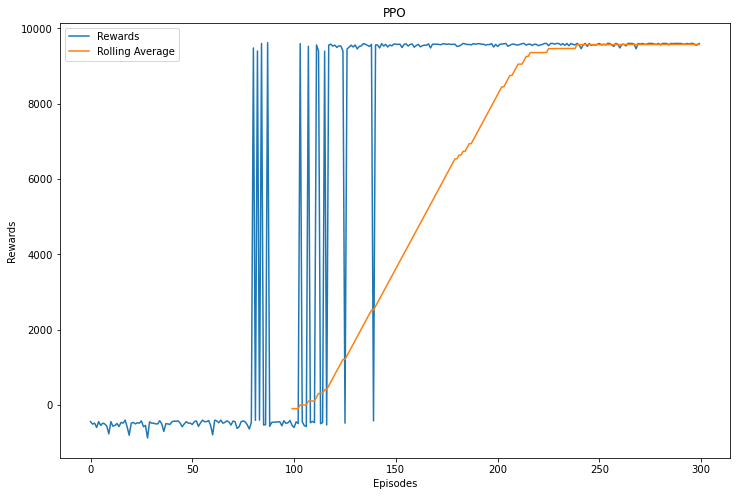

In [38]:

import pandas as pd
import matplotlib.pyplot as plt
pp_rewards = pd.Series(rewards_history[:300])
plt.figure(figsize=(12,8))

plt.plot(pp_rewards, label='Rewards')
plt.plot(pp_rewards.rolling(window=100).mean().rename("Rolling Average"), label = 'Rolling Average')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.title('PPO')

Text(0.5, 1.0, 'PPO')

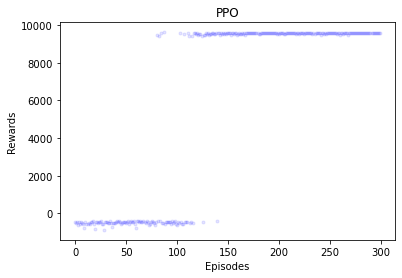

In [39]:
plt.plot(pp_rewards[:300], 'b.', alpha=.1)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('PPO')